# 1.Frame the problem

The objective of this challenge is to work with 'dirty data'. Most real data is dirty and the availability of high-quality, open-source ML and data analysis frameworks (such as [scikit-learn](https://scikit-learn.org/),
[pandas](https://pandas.pydata.org/)...) means that the next frontier for tooling and automation lies in preprocessing. This challenge aims to investigate methodologies to perform statistical analysis directly on the original dirty data.

There are two datasets in this challenge:

* `company_revenue_TRAIN.csv` - company revenue declarations.
* `award_notices_RAMP.csv` -  French Attribution Notices.

### Aim

The predictive aim of this challenge is to use `company_revenue_TRAIN.csv` and `award_notices_RAMP.csv` to predict the Revenue for each entry in the 'company financial data' dataset. It is advised that you use both datasets, as it improves the prediction (see [Score comparison](#Score-comparison)), but using only the `company_revenue_TRAIN.csv` dataset is also allowed.

### Data

### Company financial data

This dataset was built from an extract of the [National Institute of Statistics and Economic Studies (INSEE)](https://www.insee.fr/en/accueil) reference database of company revenue declarations from 2013 to 2018. Each row represents the declaration of one company for one year and the following information is provided in the columns:

* `Legal_ID` - the reconcilled legal ID of the company
* `Name` - the name of the company
* `Activity_code (APE)` - 'Activite Principale de l'Entreprise', the main activity of the company - more information in [English](https://www.startbusinessinfrance.com/code-ape) or in [French](https://www.service-public.fr/professionnels-entreprises/vosdroits/F33050)
* `Address` 
* `Zipcode`
* `City`
* `Revenue` - in Euros
* `Headcount`
* `Fiscal_year_end_date`
* `Fiscal_year_duration_in_months`
* `Year`

There are a few things to note:

* there are revenue declarations for the same company but different years
* there is a large reduction in entries for the years 2017 and 2018 due to the Loi Macron law in 2017
* the 'same company' can have several different entities, resulting in entries where the `Legal_ID` is different but the `Name`, `Address`, `City` and `Zipcode` are all the same.
* `Revenue` can be negative. A negative revenue may be due to cancelled orders from the previous fiscal year that was recorded in the current fiscal year.

In [149]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer


# 2. Get the data

In [9]:
revenue_train = pd.read_csv('data/company_revenue_public_TRAIN.csv')
revenue_test = pd.read_csv('data/company_revenue_public_TEST.csv')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# 3. Data exploration

In [10]:
revenue_train.shape

(1495948, 11)

In [37]:
revenue_train.columns

Index(['legal_id', 'name', 'ape', 'address', 'zipcode', 'city', 'revenue',
       'headcount', 'fiscal_year_end_date', 'fiscal_year_duration_in_months',
       'year'],
      dtype='object')

In [32]:
# rename columns
colnames = list(revenue_train.columns)
colnames = [x.lower() for x in colnames]
colnames = [x.replace(' ', '_') for x in colnames]
colnames[2] = 'ape'

In [35]:
revenue_train.columns = colnames

In [12]:
revenue_train.dtypes

Legal_ID                            int64
Name                               object
Activity_code (APE)                object
Address                            object
Zipcode                           float64
City                               object
Revenue                           float64
Headcount                         float64
Fiscal_year_end_date               object
Fiscal_year_duration_in_months    float64
Year                              float64
dtype: object

In [13]:
revenue_train.head()

,Legal_ID,Name,Activity_code (APE),Address,Zipcode,City,Revenue,Headcount,Fiscal_year_end_date,Fiscal_year_duration_in_months,Year
0,582296,COMICOB,NaN,BOULOUPARIS BP 15 BOULOUPARIS,NaN,NaN,104334380.0,NaN,2016-12-31,12.0,2016.0
1,582981,CIANFARANI JEAN-MICHEL,NaN,33 AVENUE H. LAFLEUR - VICTOIRE - B.P. 4031 NO...,NaN,NaN,28535069.0,NaN,2016-12-31,12.0,2016.0
2,588541,OK POULET 5EME SARL,NaN,23 RUE PAUL BERT,98800.0,NOUMEA,10481715.0,1.0,2016-12-31,12.0,2016.0
3,589275,INSTITUT DE LA QUALITE S.A.R.L.,NaN,224 RUE J. IEKAWE - COMPLEXE DE LA BELLE-VIE -...,98800.0,NOUMEA,66097924.0,NaN,2016-12-31,12.0,2016.0
4,592972,EXPERT TRADE,NaN,2 RUE DE L ASTROLABE OUEMO MAGENTA,98800.0,NOUMEA,15271453.0,NaN,2016-12-31,12.0,2016.0


In [38]:
revenue_train.isna().sum()

legal_id                               0
name                                   3
ape                                18390
address                           262234
zipcode                           251235
city                                 468
revenue                                0
headcount                         953576
fiscal_year_end_date                   0
fiscal_year_duration_in_months         0
year                                   0
dtype: int64

In [39]:
revenue_train.describe()

,legal_id,zipcode,revenue,headcount,fiscal_year_duration_in_months,year
count,1.495948e+06,1.244713e+06,1.495948e+06,5.423720e+05,1495948.0,1.495948e+06
mean,5.060829e+08,5.464419e+04,4.488752e+06,8.736985e+01,12.0,2.014475e+03
std,1.417373e+08,2.755171e+04,2.714711e+08,9.002249e+03,0.0,1.246598e+00
min,5.822960e+05,6.000000e+00,-2.207296e+07,-3.900000e+01,12.0,2.013000e+03
25%,4.149439e+08,3.185000e+04,9.456375e+04,1.000000e+00,12.0,2.013000e+03
50%,4.895445e+08,6.053000e+04,2.877205e+05,3.000000e+00,12.0,2.014000e+03
75%,5.293306e+08,7.511600e+04,1.005522e+06,9.000000e+00,12.0,2.015000e+03
max,9.999905e+08,9.889500e+04,2.427252e+11,5.450000e+06,12.0,2.018000e+03


In [70]:
revenue_train['revenue']

0          104334380.0
1           28535069.0
2           10481715.0
3           66097924.0
4           15271453.0
              ...     
1495943       643074.0
1495944     72038000.0
1495945      5224000.0
1495946     66726000.0
1495947     73261000.0
Name: revenue, Length: 1495948, dtype: float64

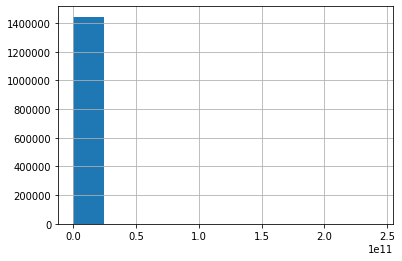

In [56]:
revenue_train['revenue'][revenue_train['revenue'] > 0].hist()

In [83]:
# number of zeros in revenues
print("number of zeros:", revenue_train[revenue_train['revenue'] == 0].shape[0])
print("number of values<1:", revenue_train[revenue_train['revenue'] <= 1].shape[0])

number of zeros: 50047
number of values<1: 51050


In [79]:
# proportion of zeros in revenues
revenue_train[revenue_train['revenue'] <= 0].shape[0] / revenue_train.shape[0]

0.03407337688208414

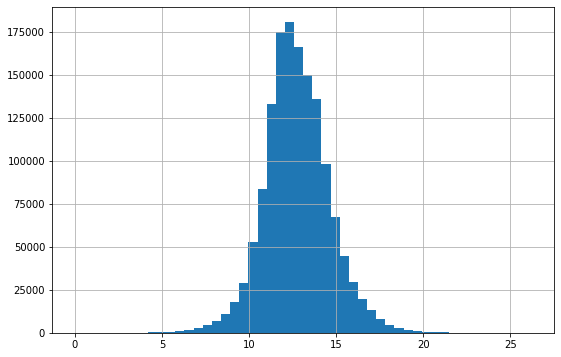

In [78]:
np.log(revenue_train['revenue'][revenue_train['revenue'] > 0]).hist(bins=50, figsize=(9,6))

# 4. Prepare the data

In [99]:
revenue_train_dropna = revenue_train.dropna(subset=['headcount'])

In [123]:
X_train = np.array(revenue_train_dropna['headcount'])
X_train = np.reshape(X_train, (-1, 1))
y_train = np.array(revenue_train_dropna['revenue'])
y_train = np.reshape(y_train, (-1, 1))

# 5. Explore models

### Linear regression

In [126]:
# fit the model
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [129]:
# predictions on train set
lin_reg_pred_train = lin_reg.predict(X_train)
lin_reg_mse = mean_squared_error(y_true=y_train, y_pred=lin_reg_pred_train)
lin_reg_rmse = np.sqrt(lin_reg_mse)

In [147]:
lin_reg_rmse

242019034.48220217

In [137]:
# cross validation
lin_reg_scores = cross_val_score(lin_reg, X=X_train, y=y_train, cv=10,
                         scoring="neg_mean_squared_error")
lin_reg_rmse_scores = np.sqrt(-lin_reg_scores)

In [138]:
lin_reg_rmse_scores.mean()

186426782.65599066

In [143]:
steps = [('lin_reg', LinearRegression())]
pipeline = Pipeline(steps)

In [144]:
pipeline.fit(X=X_train, y=y_train)

Pipeline(memory=None,
         steps=[('lin_reg',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

In [155]:
y_pred_train = pipeline.predict(X_train)

In [148]:
# R2 de la prediction
pipeline.score(X_train, y_train)

0.0007417117207769719

### Define the score

In [150]:
def loss(y_true, y_pred):
    
    if isinstance(y_true, pd.Series):
        y_true = y_true.values

    true = np.maximum(5., np.log10(np.maximum(1., y_true)))
    pred = np.maximum(5., np.log10(np.maximum(1., y_pred)))
    
    loss = np.mean(np.abs(true - pred))
    
    return loss
    
fan_loss = make_scorer(loss, greater_is_better=False)

In [159]:
loss(y_true=y_train, y_pred=y_pred_train)

1.161506150597136

# 6. Fine-tune the models

# 7. Results